<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

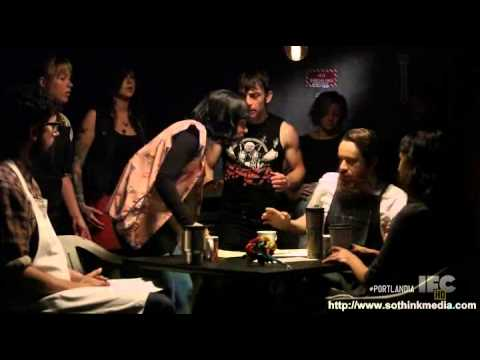

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/nickburkhalter/Desktop/Lambda School/Unit 4/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [2]:
def wrangle(df):
    df = df.copy()
    
    df['star_rating'] = df['star_rating'].str.replace(' star rating', '').astype(float)
    
    df['date'] = df['full_review_text'].str.extract(r"(\d{1,2}[/. ](?:\d{1,2}|January|Jan)[/. ]\d{2}(?:\d{2})?)")
    df['date'] = pd.to_datetime(df['date'])
    
    df['full_review_text'] = df['full_review_text'].str.replace('(\d{1,2}[/. ](?:\d{1,2}|January|Jan)[/. ]\d{2}(?:\d{2})?)', '')
    df['full_review_text'] = df['full_review_text'].str.replace('(\d*)', '').str.strip().str.lstrip('check-in ')
    df['full_review_text'] = df['full_review_text'].apply(lambda x: x.lower())
    
    df['coffee_shop_name'] = df['coffee_shop_name'].str.strip()
    
    df['positive_review'] = df['star_rating'] >= 4.0
    
    return df

In [3]:
df = wrangle(shops)
df.head()

,coffee_shop_name,full_review_text,star_rating,date,positive_review
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,5.0,2016-11-25,True
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4.0,2016-12-02,True
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4.0,2016-11-30,True
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating how...,2.0,2016-11-25,False
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4.0,2016-12-03,True


In [8]:
# Randomly sample a row to select coffee shop to examine
df.sample(1)

,coffee_shop_name,full_review_text,star_rating,date,positive_review
2184,Flat Track Coffee,"delicious coffee, on par with cuvee in my opin...",5.0,2016-01-07,True


In [4]:
df = df[df['coffee_shop_name'] == 'Flat Track Coffee']
print(df.shape)
df.head()

(63, 5)


,coffee_shop_name,full_review_text,star_rating,date,positive_review
2169,Flat Track Coffee,great place!! love a shop that has motorcycle ...,5.0,2016-11-25,True
2170,Flat Track Coffee,a friend referred me to this little coffee sho...,5.0,2016-06-09,True
2171,Flat Track Coffee,great for people watching. had a delicious dec...,4.0,2016-11-27,True
2172,Flat Track Coffee,cute coffee shop that doubles as a bike shop. ...,4.0,2016-10-28,True
2173,Flat Track Coffee,"damn good seasonal cold brew, chill atmosphere...",5.0,2016-11-21,True


In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [31]:
STOPWORDS = nlp.Defaults.stop_words.union([' ', 'coffee', 'shop'])

def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.text not in STOPWORDS) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [32]:
df['tokens'] = df['full_review_text'].apply(get_lemmas)

In [33]:
df.head()

,coffee_shop_name,full_review_text,star_rating,date,positive_review,tokens
2169,Flat Track Coffee,great place!! love a shop that has motorcycle ...,5.0,2016-11-25,True,"[great, place, love, motorcycle, love, caffein..."
2170,Flat Track Coffee,a friend referred me to this little coffee sho...,5.0,2016-06-09,True,"[friend, refer, little, cute, staff, nice, col..."
2171,Flat Track Coffee,great for people watching. had a delicious dec...,4.0,2016-11-27,True,"[great, people, watch, delicious, decaf, drip,..."
2172,Flat Track Coffee,cute coffee shop that doubles as a bike shop. ...,4.0,2016-10-28,True,"[cute, double, bike, ice, legit, barista, supe..."
2173,Flat Track Coffee,"damn good seasonal cold brew, chill atmosphere...",5.0,2016-11-21,True,"[damn, good, seasonal, cold, brew, chill, atmo..."


In [34]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [10]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [35]:
wc = count(df['tokens'])

In [36]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,good,32,53,1.0,0.024312,0.024312,0.507937
0,place,26,38,2.0,0.017431,0.041743,0.412698
89,espresso,19,36,3.0,0.016514,0.058257,0.301587
8,great,27,34,4.0,0.015596,0.073853,0.428571
224,track,15,27,5.0,0.012385,0.086239,0.238095


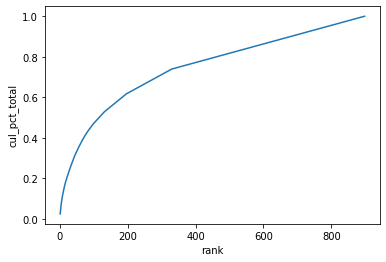

In [37]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

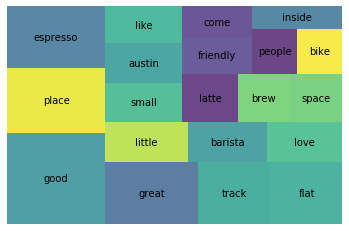

In [38]:
# Get good ratings
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

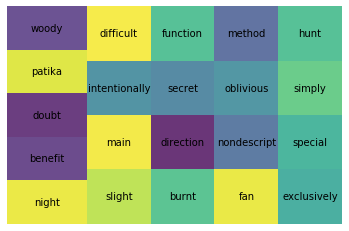

In [43]:
# Get bad ratings
wc_top20 = wc[wc['rank'] >= 878]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

/anaconda3/envs/u4s1env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


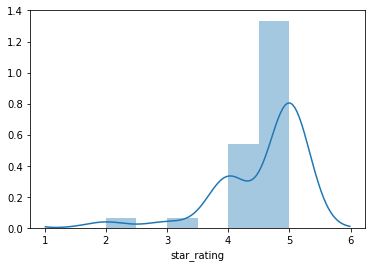

In [40]:
sns.distplot(df['star_rating']);

In [41]:
df.star_rating.describe()

count    63.000000
mean      4.571429
std       0.711978
min       2.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: star_rating, dtype: float64

In [44]:
# Isolate bad reviews
bad_reviews = df[df['star_rating'] <= 3.0]
bad_reviews.head()

,coffee_shop_name,full_review_text,star_rating,date,positive_review,tokens
2181,Flat Track Coffee,"flat track coffee is very strong, rich, and de...",3.0,2015-10-05,False,"[flat, track, strong, rich, delicious, barista..."
2204,Flat Track Coffee,cannot speak of the coffee. just the fact that...,3.0,2014-10-03,False,"[speak, fact, suppose, open, chance, try, post..."
2221,Flat Track Coffee,flat track is merely okay coffee. the baristas...,2.0,2015-05-17,False,"[flat, track, merely, okay, barista, kind, qua..."
2226,Flat Track Coffee,i was very disappointed when my boyfriend and ...,2.0,2014-04-13,False,"[disappointed, boyfriend, stop, flat, track, w..."


In [45]:
bad_wc = count(bad_reviews['tokens'])
bad_wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
25,flat,3,6,1.0,0.032787,0.032787,0.75
27,track,3,6,2.0,0.032787,0.065574,0.75
0,place,2,5,3.0,0.027322,0.092896,0.50
52,good,3,4,4.0,0.021858,0.114754,0.75
72,espresso,2,4,5.0,0.021858,0.136612,0.50


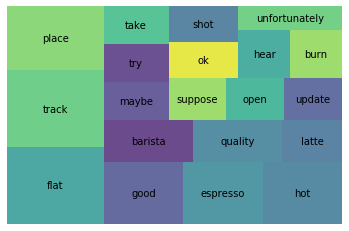

In [46]:
wc_top20 = bad_wc[bad_wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [47]:
# Isolate good reviews
good_reviews = df[df['star_rating'] >= 4.0]
good_reviews.head()

,coffee_shop_name,full_review_text,star_rating,date,positive_review,tokens
2169,Flat Track Coffee,great place!! love a shop that has motorcycle ...,5.0,2016-11-25,True,"[great, place, love, motorcycle, love, caffein..."
2170,Flat Track Coffee,a friend referred me to this little coffee sho...,5.0,2016-06-09,True,"[friend, refer, little, cute, staff, nice, col..."
2171,Flat Track Coffee,great for people watching. had a delicious dec...,4.0,2016-11-27,True,"[great, people, watch, delicious, decaf, drip,..."
2172,Flat Track Coffee,cute coffee shop that doubles as a bike shop. ...,4.0,2016-10-28,True,"[cute, double, bike, ice, legit, barista, supe..."
2173,Flat Track Coffee,"damn good seasonal cold brew, chill atmosphere...",5.0,2016-11-21,True,"[damn, good, seasonal, cold, brew, chill, atmo..."


In [49]:
good_wc = count(good_reviews['tokens'])
good_wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,good,29,49,1.0,0.024537,0.024537,0.491525
8,great,27,34,2.0,0.017026,0.041562,0.457627
0,place,24,33,3.0,0.016525,0.058087,0.406780
89,espresso,17,32,4.0,0.016024,0.074111,0.288136
222,track,12,21,5.0,0.010516,0.084627,0.203390


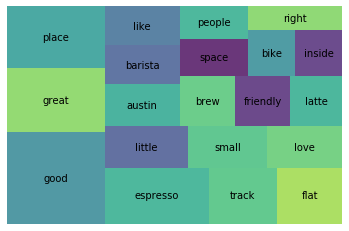

In [50]:
wc_top20 = good_wc[good_wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [51]:
bad_wc['appears_in_pct_bad'] = bad_wc['appears_in_pct']
diff = good_wc[['word', 'appears_in_pct']].merge(bad_wc[['word', 'appears_in_pct_bad']], how='outer')

diff.head(20)

,word,appears_in_pct,appears_in_pct_bad
0,good,0.491525,0.75
1,great,0.457627,NaN
2,place,0.406780,0.50
3,espresso,0.288136,0.50
4,track,0.203390,0.75
5,flat,0.186441,0.75
6,little,0.237288,0.25
7,small,0.254237,NaN
8,love,0.169492,0.25
9,austin,0.271186,0.25


In [52]:
diff['diff'] = diff['appears_in_pct'] - diff['appears_in_pct_bad']

In [54]:
diff.sort_values(by='diff').head(10)

,word,appears_in_pct,appears_in_pct_bad,diff
5,flat,0.186441,0.75,-0.563559
4,track,0.203390,0.75,-0.546610
10,barista,0.237288,0.75,-0.512712
489,ok,0.016949,0.50,-0.483051
570,unfortunately,0.016949,0.50,-0.483051
490,maybe,0.016949,0.50,-0.483051
681,take,0.016949,0.50,-0.483051
283,burn,0.033898,0.50,-0.466102
37,try,0.152542,0.50,-0.347458
14,latte,0.169492,0.50,-0.330508


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

